In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from scipy.constants import mu_0
import discretize
import time

from simpeg import maps, utils
from simpeg.electromagnetics import time_domain as tdem

import casing_utils

In [2]:
Solver = utils.solver_utils.get_default_solver()

In [5]:
sigma_back = 1e-1
sigma_air = 1e-4

target_r = 1
target_l = 50

sigma_target = 5e2
mur_target = 10

In [6]:
sigma_back, sigma_target

(0.1, 500.0)

In [7]:
rx_x = np.arange(10, 101)[::2] + 0.5
rx_x

array([ 10.5,  12.5,  14.5,  16.5,  18.5,  20.5,  22.5,  24.5,  26.5,
        28.5,  30.5,  32.5,  34.5,  36.5,  38.5,  40.5,  42.5,  44.5,
        46.5,  48.5,  50.5,  52.5,  54.5,  56.5,  58.5,  60.5,  62.5,
        64.5,  66.5,  68.5,  70.5,  72.5,  74.5,  76.5,  78.5,  80.5,
        82.5,  84.5,  86.5,  88.5,  90.5,  92.5,  94.5,  96.5,  98.5,
       100.5])

In [8]:
src_z = np.r_[-70, -60]

In [9]:
n_cells = [64, 32, 16, 8, 4, 2, 1]

In [10]:
meshes = {}

pf = 1.3

csz = 1
npadz = 28
n_core_z = int(np.max(np.abs(src_z))/csz)
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, n_core_z), (csz, npadz, pf)])

npadx = npadz

for n in n_cells: 
    hx = casing_utils.pad_for_casing_and_data(
        target_r, 
        csx1=target_r/n,
        csx2=1, #csz, 
        pfx1=pf, 
        pfx2=pf, 
        domain_x=np.max(rx_x), 
        npadx=npadx
    )
    meshes[n] = discretize.CylindricalMesh(
        [hx, [np.pi*2], hz], origin=np.r_[0, 0, -np.sum(hz[:npadz+n_core_z])]
    )

/home/lheagy/git/simpeg-research/2025-permeable-wells-cami/casing_utils.py:99: RuntimeWarning: invalid value encountered in scalar divide
  hx1b *= (dx1*csx2 - np.sum(hx1a))/np.sum(hx1b)


<Axes: xlabel='x', ylabel='z'>

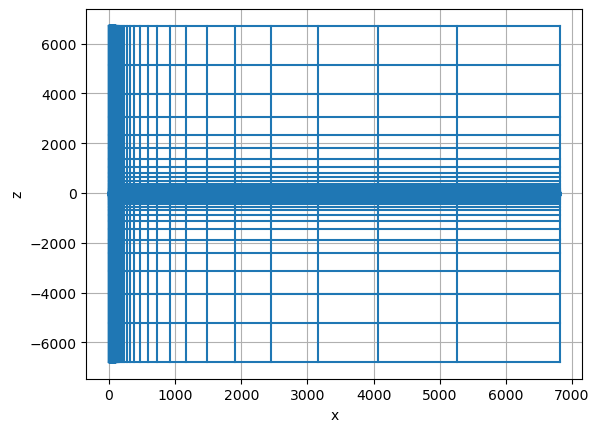

In [11]:
meshes[1].plot_grid()

In [12]:
models = {}

for n in n_cells: 
    mesh = meshes[n]
    
    sigma = np.ones(mesh.n_cells) * sigma_air
    sigma[mesh.cell_centers[:, 2] < 0] = sigma_back

    inds_target = (
        (mesh.cell_centers[:, 0] < target_r) &
        (mesh.cell_centers[:, 2] < 0) & 
        (mesh.cell_centers[:, 2] > -target_l)
    )
    sigma[inds_target] = sigma_target

    mur = np.ones(mesh.n_cells) 
    mur[inds_target] = mur_target

    models[n] = {
        "sigma":sigma,
        "mur": mur
    }

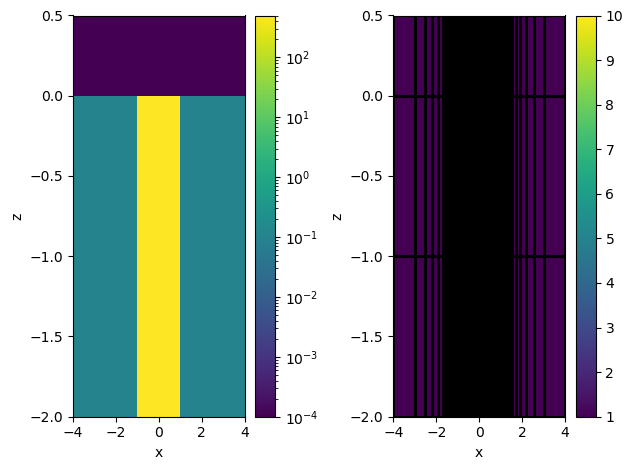

In [13]:
n_plot = n_cells[0]

fig, ax = plt.subplots(1, 2)

mesh = meshes[n_plot]
model = models[n_plot]

plt.colorbar(mesh.plot_image(
    model["sigma"],
    pcolor_opts={"norm":LogNorm()},
    mirror=True,
    ax=ax[0],
    
)[0], ax=ax[0])

plt.colorbar(mesh.plot_image(
    model["mur"],
    pcolor_opts={"norm":Normalize()},
    mirror=True,
    grid=True,
    ax=ax[1]
)[0], ax=ax[1])

for a in ax: 
    a.set_xlim(np.r_[-1, 1]*4),
    a.set_ylim(np.r_[-2, 0.5])

plt.tight_layout()

In [14]:
rx_times = np.logspace(-5, -3, 20)

In [15]:
mesh = meshes[n_cells[0]]

In [16]:
def get_survey(mesh): 
    rx = tdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], np.r_[-0.25]),
        orientation="x",
        times=rx_times, 
    )
    
    src_inds = (
        (mesh.faces_z[:, 0] < target_r) &
        (mesh.faces_z[:, 2] < src_z.max()) &
        (mesh.faces_z[:, 2] > src_z.min())
    )
    
    jz = np.zeros(mesh.n_faces_z)
    jz[src_inds] = 1
    
    src = tdem.sources.RawVec_Grounded(
        receiver_list = [rx], 
        s_e = np.hstack([np.zeros(mesh.n_faces_x), jz])
    )


# src = tdem.sources.LineCurrent(
#     receiver_list = [rx],
#     location = np.array([
#         [0, 0, src_z.min()], 
#         [0, 0, src_z.max()], 
#     ])
# )
    
    return tdem.Survey([src])

In [17]:
time_steps = [
    (1e-6, 20),
    (3e-6, 20),
    (1e-5, 20), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
]

In [18]:
simulations = {}

for n in n_cells: 
    mesh = meshes[n]
    survey = get_survey(mesh)
    simulations[n] = tdem.Simulation3DMagneticField(
        mesh=mesh,
        survey=survey, 
        time_steps=time_steps, 
        sigmaMap=maps.IdentityMap(mesh), 
        solver=Solver
    )

In [19]:
dpred_conductive = {}
dpred_permeable = {}
fields_conductive = {}
fields_permeable = {}

for n, sim in simulations.items():
    print(f"Starting {n} conductive ...")
    t0 = time.time()
    fields_conductive[n] = sim.fields(models[n]["sigma"])
    dpred_conductive[n] = sim.dpred(models[n]["sigma"], f=fields_conductive[n])
    print(f" ... done. Time: {time.time()-t0:1.1e}s")

    print(f"Starting {n} conductive, permeable ...")
    t0 = time.time()
    sim.mu = mu_0 * models[n]["mur"]
    fields_permeable[n] = sim.fields(models[n]["sigma"])
    dpred_permeable[n] = sim.dpred(models[n]["sigma"], f=fields_permeable[n])
    print(f" ... done. Time: {time.time()-t0:1.1e}s")

Starting 64 conductive ...


/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/direct/pardiso.py:49: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format.
  self.solver = MKLPardisoSolver(
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


 ... done. Time: 1.9e+00s
Starting 64 conductive, permeable ...
 ... done. Time: 1.4e+00s
Starting 32 conductive ...
 ... done. Time: 1.2e+00s
Starting 32 conductive, permeable ...
 ... done. Time: 1.0e+00s
Starting 16 conductive ...
 ... done. Time: 1.3e+00s
Starting 16 conductive, permeable ...
 ... done. Time: 1.1e+00s
Starting 8 conductive ...
 ... done. Time: 1.1e+00s
Starting 8 conductive, permeable ...
 ... done. Time: 8.7e-01s
Starting 4 conductive ...
 ... done. Time: 9.7e-01s
Starting 4 conductive, permeable ...
 ... done. Time: 8.7e-01s
Starting 2 conductive ...
 ... done. Time: 9.5e-01s
Starting 2 conductive, permeable ...
 ... done. Time: 8.5e-01s
Starting 1 conductive ...
 ... done. Time: 9.6e-01s
Starting 1 conductive, permeable ...
 ... done. Time: 8.4e-01s


In [20]:
n_cells

[64, 32, 16, 8, 4, 2, 1]

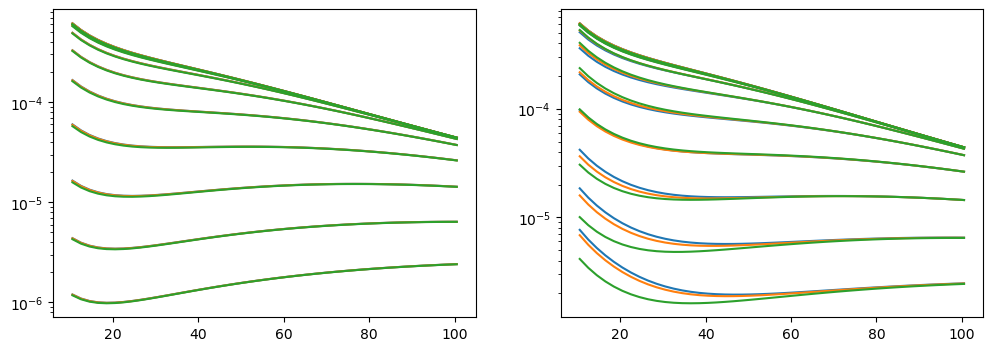

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i, n in enumerate([64, 4, 2]): 
    ax[0].semilogy(rx_x, dpred_conductive[n].reshape(len(rx_times), len(rx_x))[::2, :].T, color=f"C{i}", label=n);
    ax[1].semilogy(rx_x, dpred_permeable[n].reshape(len(rx_times), len(rx_x))[::2, :].T, color=f"C{i}", label=n);

# ax[0].legend()

In [278]:
n_cells

[64, 32, 16, 8, 4, 2, 1]

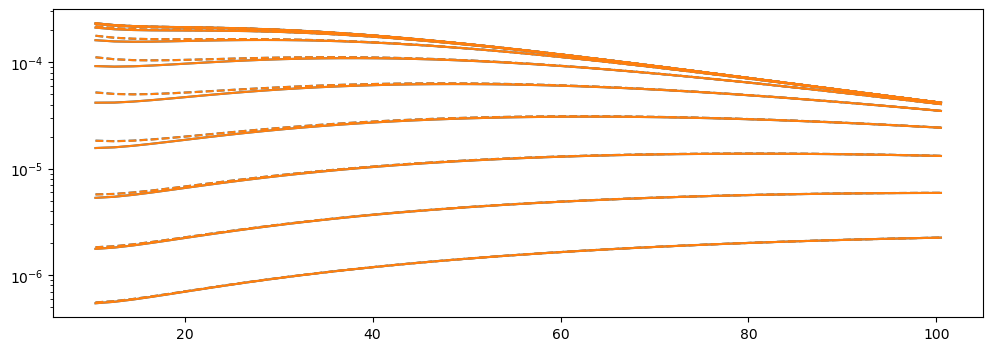

In [279]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for i, n in enumerate([64, 4]): 
    ax.semilogy(rx_x, dpred_conductive[n].reshape(len(rx_times), len(rx_x))[::2, :].T, color=f"C{i}", label=n);
    ax.semilogy(rx_x, dpred_permeable[n].reshape(len(rx_times), len(rx_x))[::2, :].T, f"--C{i}", label=n);
